In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

In [ ]:
clinical_data = pd.read_csv("/content/clinical_data.csv",low_memory=False, dtype=str)
clinical_data.head()

,CGGA_ID,Subtype,Histology,Grade,Gender,Age,OS,Censor (alive=0; dead=1),Radio_status (treated=1;un-treated=0),Chemo_status (TMZ treated=1;un-treated=0),IDH_mut_status,1p19q_codeletion_status,MGMTp_methylation_status
0,CGGA_528,Primary LGG,A,WHO II,Female,51,2424,1,1,0,Wildtype,NaN,un-methylated
1,CGGA_579,Primary LGG,O,WHO II,Female,42,2125,1,1,0,Wildtype,NaN,un-methylated
2,CGGA_653,Primary LGG,OA,WHO II,Male,33,3605,0,1,0,Mutant,NaN,methylated
3,CGGA_715,Primary LGG,O,WHO II,Male,43,3429,0,1,0,Mutant,Codel,methylated
4,CGGA_723,Primary LGG,AOA,WHO III,Female,25,4151,0,0,1,Mutant,NaN,un-methylated


In [ ]:
# Display all column names of the clinical data
print("\nColumn names of the clinical data:")
print(clinical_data.columns)


Column names of the clinical data:
Index(['CGGA_ID', 'Subtype', 'Histology', 'Grade', 'Gender', 'Age', 'OS',
       'Censor (alive=0; dead=1)', 'Radio_status (treated=1;un-treated=0)',
       'Chemo_status (TMZ treated=1;un-treated=0)', 'IDH_mut_status',
       '1p19q_codeletion_status', 'MGMTp_methylation_status'],
      dtype='object')


In [ ]:
# Convert specific columns to numerical data type
columns_to_convert = ['Age', 'OS', 'Censor (alive=0; dead=1)',
                      'Radio_status (treated=1;un-treated=0)', 'Chemo_status (TMZ treated=1;un-treated=0)']

for column in columns_to_convert:
    clinical_data[column] = pd.to_numeric(clinical_data[column], errors='coerce')

# Verify the data types after conversion
print(clinical_data.dtypes)


CGGA_ID                                       object
Subtype                                       object
Histology                                     object
Grade                                         object
Gender                                        object
Age                                            int64
OS                                           float64
Censor (alive=0; dead=1)                     float64
Radio_status (treated=1;un-treated=0)        float64
Chemo_status (TMZ treated=1;un-treated=0)    float64
IDH_mut_status                                object
1p19q_codeletion_status                       object
MGMTp_methylation_status                      object
dtype: object


In [ ]:
# Display the shape of the clinical data (number of rows and columns)
print("Shape of clinical data:", clinical_data.shape)
# Display basic information about the clinical data
print("\nInfo about clinical data:")
clinical_data.info()

Shape of clinical data: (286, 13)

Info about clinical data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   CGGA_ID                                    286 non-null    object 
 1   Subtype                                    286 non-null    object 
 2   Histology                                  286 non-null    object 
 3   Grade                                      286 non-null    object 
 4   Gender                                     286 non-null    object 
 5   Age                                        286 non-null    int64  
 6   OS                                         266 non-null    float64
 7   Censor (alive=0; dead=1)                   271 non-null    float64
 8   Radio_status (treated=1;un-treated=0)      270 non-null    float64
 9   Chemo_status (TMZ treated=1;un-treate

In [ ]:
# Display summary statistics for numerical columns in the clinical data
print("\nSummary statistics for numerical columns:")
print(clinical_data.describe())


Summary statistics for numerical columns:
              Age           OS  Censor (alive=0; dead=1)  \
count  286.000000   266.000000                271.000000   
mean    41.968531  1281.973684                  0.531365   
std     12.339171  1064.178118                  0.499938   
min     10.000000    41.000000                  0.000000   
25%     33.000000   334.500000                  0.000000   
50%     41.000000   951.500000                  1.000000   
75%     49.000000  1705.500000                  1.000000   
max     76.000000  4151.000000                  1.000000   

       Radio_status (treated=1;un-treated=0)  \
count                             270.000000   
mean                                0.855556   
std                                 0.352193   
min                                 0.000000   
25%                                 1.000000   
50%                                 1.000000   
75%                                 1.000000   
max                             

In [ ]:
# Check for missing values in the clinical data
print("\nMissing values in clinical data:")
print(clinical_data.isnull().sum())


Missing values in clinical data:
CGGA_ID                                        0
Subtype                                        0
Histology                                      0
Grade                                          0
Gender                                         0
Age                                            0
OS                                            20
Censor (alive=0; dead=1)                      15
Radio_status (treated=1;un-treated=0)         16
Chemo_status (TMZ treated=1;un-treated=0)     25
IDH_mut_status                                 0
1p19q_codeletion_status                       96
MGMTp_methylation_status                     102
dtype: int64


In [ ]:
# Impute missing values for 'OS' using median
clinical_data['OS'].fillna(clinical_data['OS'].median(), inplace=True)

# Impute missing values for categorical variables using mode
categorical_cols = ['Censor (alive=0; dead=1)', 'Radio_status (treated=1;un-treated=0)',
                    'Chemo_status (TMZ treated=1;un-treated=0)', '1p19q_codeletion_status',
                    'MGMTp_methylation_status']

for col in categorical_cols:
    clinical_data[col].fillna(clinical_data[col].mode()[0], inplace=True)


In [ ]:
print("\nMissing values in clinical data:")
print(clinical_data.isnull().sum())


Missing values in clinical data:
CGGA_ID                                      0
Subtype                                      0
Histology                                    0
Grade                                        0
Gender                                       0
Age                                          0
OS                                           0
Censor (alive=0; dead=1)                     0
Radio_status (treated=1;un-treated=0)        0
Chemo_status (TMZ treated=1;un-treated=0)    0
IDH_mut_status                               0
1p19q_codeletion_status                      0
MGMTp_methylation_status                     0
dtype: int64


In [ ]:
# Check for unique values in categorical columns
print("\nUnique values in categorical columns:")
categorical_columns = ["Subtype", "Histology", "Grade", "Gender", "IDH_mut_status", "1p19q_codeletion_status", "MGMTp_methylation_status"]
for column in categorical_columns:
    print(column + ":")
    print(clinical_data[column].value_counts())
    print()


Unique values in categorical columns:
Subtype:
Primary LGG      126
Recurrent LGG     58
Primary GBM       54
Recurrent GBM     48
Name: Subtype, dtype: int64

Histology:
GBM     54
rGBM    48
A       40
AA      31
rAA     28
O       25
rA      13
AO      12
rAO     11
OA      10
AOA      8
rO       5
rAOA     1
Name: Histology, dtype: int64

Grade:
WHO IV     102
WHO II      93
WHO III     91
Name: Grade, dtype: int64

Gender:
Male      168
Female    118
Name: Gender, dtype: int64

IDH_mut_status:
Mutant      161
Wildtype    125
Name: IDH_mut_status, dtype: int64

1p19q_codeletion_status:
Non-codel    235
Codel         51
Name: 1p19q_codeletion_status, dtype: int64

MGMTp_methylation_status:
methylated       221
un-methylated     65
Name: MGMTp_methylation_status, dtype: int64



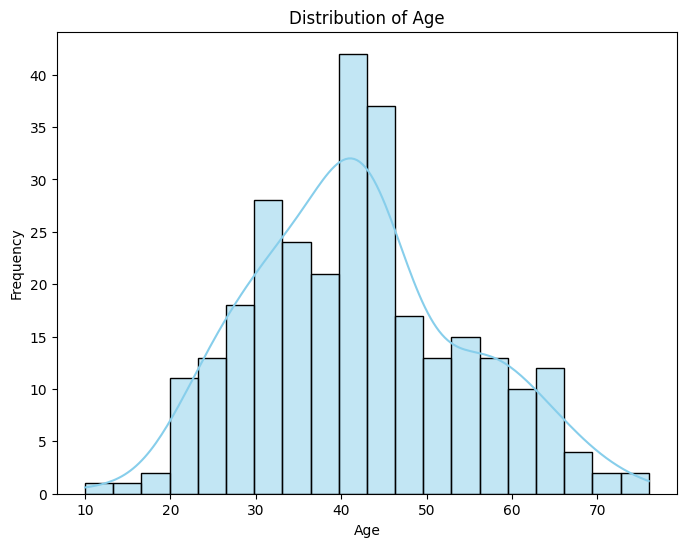

In [ ]:
# Histogram of Age
plt.figure(figsize=(8, 6))
sns.histplot(clinical_data['Age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

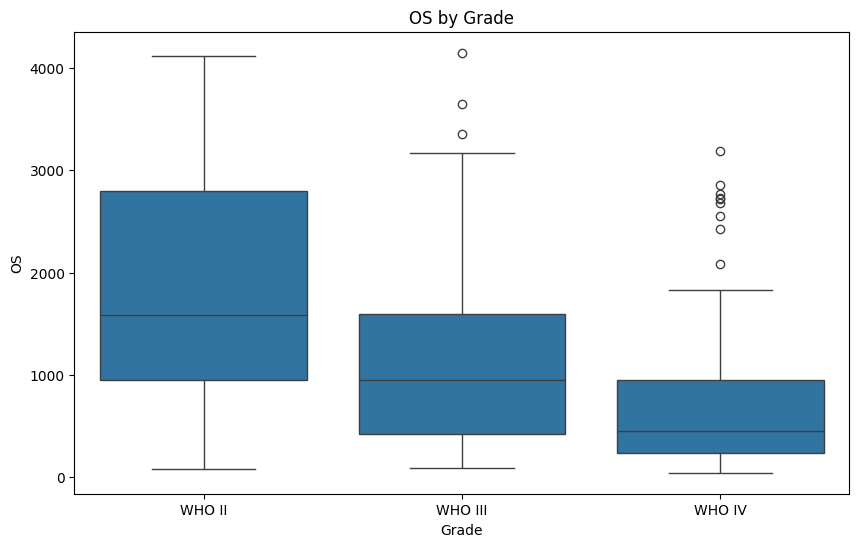

In [ ]:
# Boxplot of OS by Grade
plt.figure(figsize=(10, 6))
sns.boxplot(x='Grade', y='OS', data=clinical_data)
plt.title('OS by Grade')
plt.xlabel('Grade')
plt.ylabel('OS')
plt.show()

<ipython-input-120-17d1a227e82b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = clinical_data.corr()


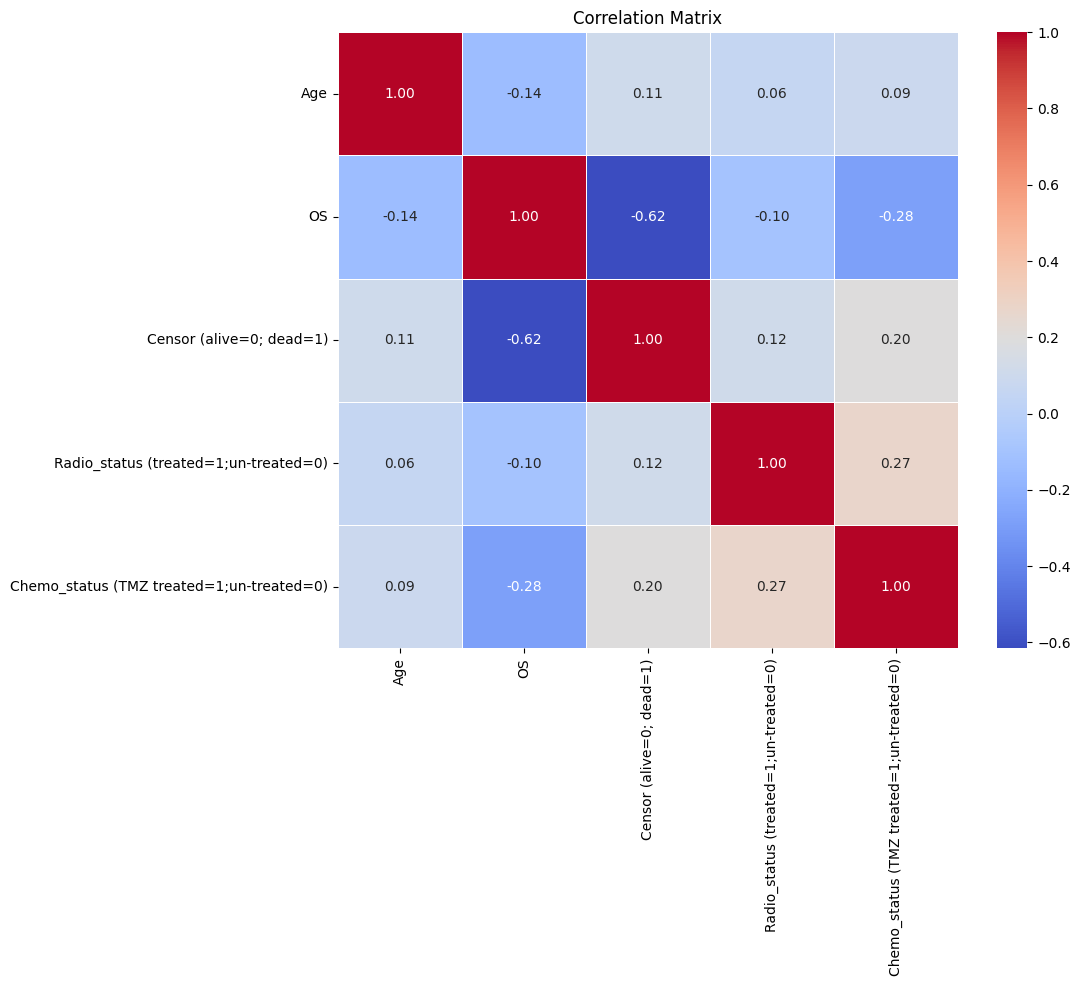

In [ ]:
# Correlation Matrix
corr_matrix = clinical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

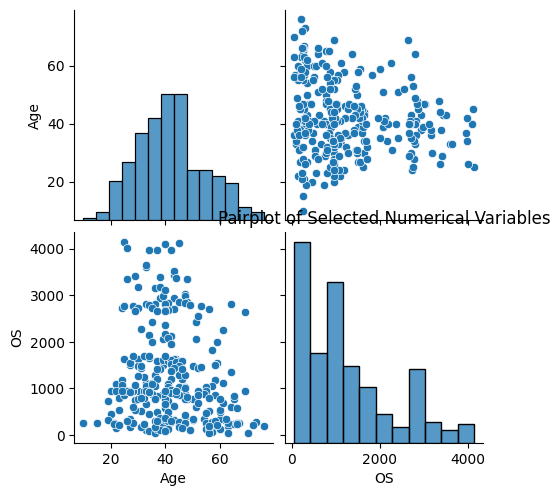

In [ ]:
# Pairplot for selected numerical variables
selected_numerical_cols = ['Age', 'OS']
sns.pairplot(clinical_data[selected_numerical_cols])
plt.title('Pairplot of Selected Numerical Variables')
plt.show()

In [ ]:
# Convert categorical variables to dummy variables
clinical_data = pd.get_dummies(clinical_data, columns=['Subtype', 'Histology', 'Gender',
                                                      'Censor (alive=0; dead=1)',
                                                      'Radio_status (treated=1;un-treated=0)',
                                                      'Chemo_status (TMZ treated=1;un-treated=0)',
                                                      'IDH_mut_status',
                                                      '1p19q_codeletion_status',
                                                      'MGMTp_methylation_status'],
                             drop_first=True)

# Check the shape of the dataset after encoding categorical variables
print("Shape of clinical data after encoding categorical variables:", clinical_data.shape)


Shape of clinical data after encoding categorical variables: (286, 26)


In [ ]:
wes_data = pd.read_csv("/content/wes_data.csv",low_memory=False, dtype=str)
wes_data.head()

,Unnamed: 0,CGGA_528,CGGA_579,CGGA_653,CGGA_715,CGGA_723,CGGA_726,CGGA_755,CGGA_762,CGGA_785,...,CGGA_P625,CGGA_P633,CGGA_P83,CGGA_P84,CGGA_P86,CGGA_P87,CGGA_P89,CGGA_P90,CGGA_P95,CGGA_P99
0,A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,multiple_variant,NaN,NaN,NaN,NaN
1,A2M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A2ML1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A3GALT2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A4GALT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Replace NaN values with 'No mutation'
wes_data.fillna('no_mutation', inplace=True)
# Check the updated DataFrame
wes_data.head()

,Unnamed: 0,CGGA_528,CGGA_579,CGGA_653,CGGA_715,CGGA_723,CGGA_726,CGGA_755,CGGA_762,CGGA_785,...,CGGA_P625,CGGA_P633,CGGA_P83,CGGA_P84,CGGA_P86,CGGA_P87,CGGA_P89,CGGA_P90,CGGA_P95,CGGA_P99
0,A1CF,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,...,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,multiple_variant,no_mutation,no_mutation,no_mutation,no_mutation
1,A2M,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,...,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation
2,A2ML1,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,...,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation
3,A3GALT2,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,...,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation
4,A4GALT,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,...,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation,no_mutation


In [ ]:
# Extract unique mutation types
mutation_types = wes_data.iloc[:, 1:].stack().unique()
print("Types of mutations present in the dataset:")
print(mutation_types)


Types of mutations present in the dataset:
['no_mutation' 'stop_gained' 'multiple_variant' 'missense_variant'
 'frameshift_variant' 'inframe_insertion' 'disruptive_inframe_deletion'
 'inframe_deletion' 'stop_lost' 'start_lost' 'synonymous_variant'
 'disruptive_inframe_insertion']


In [ ]:
# Frequency of Mutation Types
mutation_freq = wes_data.iloc[:, 1:].apply(pd.Series.value_counts)
print("\nFrequency of Mutation Types:")
print(mutation_freq)



Frequency of Mutation Types:
                              CGGA_528  CGGA_579  CGGA_653  CGGA_715  \
disruptive_inframe_deletion        NaN       NaN       NaN       NaN   
disruptive_inframe_insertion       NaN       NaN       NaN       NaN   
frameshift_variant                 NaN       NaN       1.0       1.0   
inframe_deletion                   NaN       NaN       NaN       NaN   
inframe_insertion                  NaN       NaN       NaN       NaN   
missense_variant                   1.0       3.0       9.0       9.0   
multiple_variant                   1.0       NaN       2.0       5.0   
no_mutation                    12572.0   12570.0   12561.0   12558.0   
start_lost                         NaN       NaN       NaN       NaN   
stop_gained                        NaN       1.0       1.0       1.0   
stop_lost                          NaN       NaN       NaN       NaN   
synonymous_variant                 NaN       NaN       NaN       NaN   

                              CGG

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Flatten the mutation types array and remove NaN values
mutation_types_flat = mutation_types.flatten()
mutation_types_flat = mutation_types_flat[~pd.isnull(mutation_types_flat)]

# Fit label encoder and transform mutation types to numerical values
encoded_mutation_types = label_encoder.fit_transform(mutation_types_flat)

# Print the mapping of original mutation types to encoded numerical values
print("Mapping of original mutation types to encoded numerical values:")
for original, encoded in zip(mutation_types_flat, encoded_mutation_types):
    print(f"{original}: {encoded}")


Mapping of original mutation types to encoded numerical values:
no_mutation: 7
stop_gained: 9
multiple_variant: 6
missense_variant: 5
frameshift_variant: 2
inframe_insertion: 4
disruptive_inframe_deletion: 0
inframe_deletion: 3
stop_lost: 10
start_lost: 8
synonymous_variant: 11
disruptive_inframe_insertion: 1


In [ ]:
# Replace original mutation types with encoded numerical values in the dataset
wes_data_encoded = wes_data.replace(dict(zip(mutation_types_flat, encoded_mutation_types)))

# Check the updated DataFrame with encoded mutation types
wes_data_encoded.head()


,Unnamed: 0,CGGA_528,CGGA_579,CGGA_653,CGGA_715,CGGA_723,CGGA_726,CGGA_755,CGGA_762,CGGA_785,...,CGGA_P625,CGGA_P633,CGGA_P83,CGGA_P84,CGGA_P86,CGGA_P87,CGGA_P89,CGGA_P90,CGGA_P95,CGGA_P99
0,A1CF,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,6,7,7,7,7
1,A2M,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
2,A2ML1,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
3,A3GALT2,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
4,A4GALT,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7


In [ ]:
# Transpose wes_data and set the first row as column names
wes_data_transposed = wes_data_encoded.T.reset_index()
wes_data_transposed.columns = wes_data_transposed.iloc[0]  # Set the first row as column names
wes_data_transposed = wes_data_transposed[1:]  # Drop the first row, as it is now the column names
wes_data_transposed.rename(columns={'Unnamed: 0': 'CGGA_ID'}, inplace=True)

# Reset index and rename the index column
wes_data_transposed = wes_data_transposed.reset_index(drop=True).rename_axis(None, axis=1)

# Verify the result
print(wes_data_transposed.head())


    CGGA_ID A1CF A2M A2ML1 A3GALT2 A4GALT A4GNT AAAS AADAC, AADACL2-AS1  \
0  CGGA_528    7   7     7       7      7     7    7                  7   
1  CGGA_579    7   7     7       7      7     7    7                  7   
2  CGGA_653    7   7     7       7      7     7    7                  7   
3  CGGA_715    7   7     7       7      7     7    7                  7   
4  CGGA_723    7   7     7       7      7     7    7                  7   

  AADACL2, MIR548H2, AADACL2-AS1  ... ZW10 ZWILCH ZXDA ZXDB ZXDC ZYG11A  \
0                              7  ...    7      7    7    7    7      7   
1                              7  ...    7      7    7    7    7      7   
2                              7  ...    7      7    7    7    7      7   
3                              7  ...    7      7    7    7    7      7   
4                              7  ...    7      7    7    7    7      7   

  ZYG11B ZYX ZZEF1 ZZZ3  
0      7   7     7    7  
1      7   7     7    7  
2      7   7     7  

In [ ]:
# Merge datasets on 'CGGA_ID'
combined_data = pd.merge(clinical_data, wes_data_transposed, on='CGGA_ID')
combined_data.head()

,CGGA_ID,Grade,Age,OS,Subtype_Primary LGG,Subtype_Recurrent GBM,Subtype_Recurrent LGG,Histology_AA,Histology_AO,Histology_AOA,...,ZW10,ZWILCH,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,CGGA_528,WHO II,51,2424.0,1,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7
1,CGGA_579,WHO II,42,2125.0,1,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7
2,CGGA_653,WHO II,33,3605.0,1,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7
3,CGGA_715,WHO II,43,3429.0,1,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7
4,CGGA_723,WHO III,25,4151.0,1,0,0,0,0,1,...,7,7,7,7,7,7,7,7,7,7


In [ ]:
print("Number of columns in combined_data:", len(combined_data.columns))
print("List of columns in combined_data:", combined_data.columns.tolist())

Number of columns in combined_data: 12600
List of columns in combined_data: ['CGGA_ID', 'Grade', 'Age', 'OS', 'Subtype_Primary LGG', 'Subtype_Recurrent GBM', 'Subtype_Recurrent LGG', 'Histology_AA', 'Histology_AO', 'Histology_AOA', 'Histology_GBM', 'Histology_O', 'Histology_OA', 'Histology_rA', 'Histology_rAA', 'Histology_rAO', 'Histology_rAOA', 'Histology_rGBM', 'Histology_rO', 'Gender_Male', 'Censor (alive=0; dead=1)_1.0', 'Radio_status (treated=1;un-treated=0)_1.0', 'Chemo_status (TMZ treated=1;un-treated=0)_1.0', 'IDH_mut_status_Wildtype', '1p19q_codeletion_status_Non-codel', 'MGMTp_methylation_status_un-methylated', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS', 'AADAC, AADACL2-AS1', 'AADACL2, MIR548H2, AADACL2-AS1', 'AADACL3', 'AADACL4', 'AAED1', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AANAT', 'AARS', 'AARS2', 'AASDH', 'AASS', 'AATF', 'AATK', 'ABAT', 'ABCA1', 'ABCA10', 'ABCA12', 'ABCA12, LOC101928103', 'ABCA13', 'ABCA2', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', 'ABCA7', 'ABC

In [ ]:
gene_columns = combined_data.columns[26:]

In [ ]:
# Convert gene columns to float64 data type
combined_data[gene_columns] = combined_data[gene_columns].astype('float64')

# Verify the data types after conversion
print("Updated data types of gene columns:")
print(combined_data[gene_columns].dtypes)

Updated data types of gene columns:
A1CF       float64
A2M        float64
A2ML1      float64
A3GALT2    float64
A4GALT     float64
            ...   
ZYG11A     float64
ZYG11B     float64
ZYX        float64
ZZEF1      float64
ZZZ3       float64
Length: 12574, dtype: object


In [ ]:
missing_values = combined_data.isnull().sum()
print("Missing values in the combined data:\n", missing_values)

Missing values in the combined data:
 CGGA_ID                0
Grade                  0
Age                    0
OS                     0
Subtype_Primary LGG    0
                      ..
ZYG11A                 0
ZYG11B                 0
ZYX                    0
ZZEF1                  0
ZZZ3                   0
Length: 12600, dtype: int64


In [ ]:
# Calculate median OS for each grade
median_os_by_grade = combined_data.groupby('Grade')['OS'].median()

print("Median Overall Survival (OS) by Grade:")
print(median_os_by_grade)


Median Overall Survival (OS) by Grade:
Grade
WHO II     1586.0
WHO III     951.5
WHO IV      449.5
Name: OS, dtype: float64


In [ ]:
# Define recurrence thresholds for different glioma grades
recurrence_thresholds = {
    'WHO II': 1586,
    'WHO III': 951.5,
    'WHO IV': 449.5
}

# Define the target variable based on survival time and glioma grade
combined_data['Glioma_Recurrence'] = combined_data.apply(
    lambda row: row['OS'] < recurrence_thresholds[row['Grade']], axis=1
)

# Count the number of 'True' and 'False' values in the 'Glioma_Recurrence' column
recurrence_counts = combined_data['Glioma_Recurrence'].value_counts()

print("Number of Glioma Recurrences (True):", recurrence_counts[True])
print("Number of No Glioma Recurrences (False):", recurrence_counts[False])


Number of Glioma Recurrences (True): 140
Number of No Glioma Recurrences (False): 146


In [ ]:
combined_data.head()

,CGGA_ID,Grade,Age,OS,Subtype_Primary LGG,Subtype_Recurrent GBM,Subtype_Recurrent LGG,Histology_AA,Histology_AO,Histology_AOA,...,ZWILCH,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,Glioma_Recurrence
0,CGGA_528,WHO II,51,2424.0,1,0,0,0,0,0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,False
1,CGGA_579,WHO II,42,2125.0,1,0,0,0,0,0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,False
2,CGGA_653,WHO II,33,3605.0,1,0,0,0,0,0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,False
3,CGGA_715,WHO II,43,3429.0,1,0,0,0,0,0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,False
4,CGGA_723,WHO III,25,4151.0,1,0,0,0,0,1,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,False


In [ ]:
# Drop irrelevant columns and columns that leak information about the target variable
X = combined_data.drop(columns=['CGGA_ID','OS', 'Glioma_Recurrence'])
y = combined_data['Glioma_Recurrence']

In [ ]:
# Encode the 'Grade' column using one-hot encoding
encoder = OneHotEncoder(sparse=False, drop='first')  # Drop first category to avoid multicollinearity
X_encoded = encoder.fit_transform(X[['Grade']])

# Concatenate encoded features with remaining features
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(['Grade']))
X_processed = pd.concat([X.drop(columns=['Grade']), X_encoded_df], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate Model Performance
y_pred = rf_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

       False       0.63      0.80      0.71        30
        True       0.70      0.50      0.58        28

    accuracy                           0.66        58
   macro avg       0.67      0.65      0.64        58
weighted avg       0.66      0.66      0.65        58

Confusion Matrix:
[[24  6]
 [14 14]]


In [ ]:
# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train, y_train)

# Evaluate Model Performance
y_pred = best_rf_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.6583574879227053
Classification Report:
              precision    recall  f1-score   support

       False       0.63      0.80      0.71        30
        True       0.70      0.50      0.58        28

    accuracy                           0.66        58
   macro avg       0.67      0.65      0.64        58
weighted avg       0.66      0.66      0.65        58

Confusion Matrix:
[[24  6]
 [14 14]]


In [ ]:
# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Perform Randomized Search Cross Validation
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid,
                                   n_iter=50, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train, y_train)

# Evaluate Model Performance
y_pred = best_rf_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}
Best Score: 0.6492753623188405
Classification Report:
              precision    recall  f1-score   support

       False       0.58      0.93      0.72        30
        True       0.80      0.29      0.42        28

    accuracy                           0.62        58
   macro avg       0.69      0.61      0.57        58
weighted avg       0.69      0.62      0.57        58

Confusion Matrix:
[[28  2]
 [20  8]]


In [ ]:
# Initialize Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Evaluate Model Performance
y_pred_gb = gb_model.predict(X_test)
print("Gradient Boosting Classifier - Classification Report:")
print(classification_report(y_test, y_pred_gb))
print("Gradient Boosting Classifier - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

Gradient Boosting Classifier - Classification Report:
              precision    recall  f1-score   support

       False       0.66      0.70      0.68        30
        True       0.65      0.61      0.63        28

    accuracy                           0.66        58
   macro avg       0.66      0.65      0.65        58
weighted avg       0.66      0.66      0.65        58

Gradient Boosting Classifier - Confusion Matrix:
[[21  9]
 [11 17]]


In [ ]:
# Define hyperparameters to tune
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Initialize Grid Search Cross Validation
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=5, scoring='accuracy', verbose=1)

# Perform Grid Search Cross Validation
grid_search_gb.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search_gb.best_params_)
print("Best Score:", grid_search_gb.best_score_)

# Evaluate Model Performance with Best Parameters
best_gb_model = grid_search_gb.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test)
print("Gradient Boosting Classifier - Classification Report:")
print(classification_report(y_test, y_pred_best_gb))
print("Gradient Boosting Classifier - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_gb))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Score: 0.6665700483091788
Gradient Boosting Classifier - Classification Report:
              precision    recall  f1-score   support

       False       0.68      0.70      0.69        30
        True       0.67      0.64      0.65        28

    accuracy                           0.67        58
   macro avg       0.67      0.67      0.67        58
weighted avg       0.67      0.67      0.67        58

Gradient Boosting Classifier - Confusion Matrix:
[[21  9]
 [10 18]]


In [155]:
# Initialize the SVM classifier
svm_classifier = SVC()

# Define the grid of hyperparameters to search
#param_grid = {
 #   'C': [0.1, 1, 10, 100],
  #  'gamma': [1, 0.1, 0.01, 0.001],
  #  'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
#}
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    # Add more hyperparameters as needed
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the SVM model with the best parameters
best_svm_model = SVC(**best_params)
best_svm_model.fit(X_train, y_train)

# Evaluate Model Performance
y_pred_svm = best_svm_model.predict(X_test)
print("SVM - Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Best Parameters: {'C': 0.1, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
Best Score: 0.5743961352657004
SVM - Classification Report:
              precision    recall  f1-score   support

       False       0.60      0.90      0.72        30
        True       0.77      0.36      0.49        28

    accuracy                           0.64        58
   macro avg       0.68      0.63      0.60        58
weighted avg       0.68      0.64      0.61        58

SVM - Confusion Matrix:
[[27  3]
 [18 10]]
